In [113]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy,
    construct_features_sbert_embeddings,
    construct_features_sbert_embeddings_PCA,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_split_flatten_masked,
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os

import joblib
import nibabel as nib

model_path = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD/model_sub1_split0_splittotalnum_2_single_motion.joblib"
R2_file = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD/R2_score_single_sub1_motion_train0_splittotalnum_2_test1_fw.nii.gz"

model = joblib.load(model_path)

glmsingle_access = GLMSingleAccess()
stimuli_info_access = StimuliInfoAccess()

sub = 1
n_splits = 2
# n_splits = 5
split_index_train = 0
# split_index_test = 1#################
split_index_test = 1
Xcentered = False
Ycentered = True    
direction = "fw"
randomize = True


def mask_construct(R2_file, threshold=0.14):
    R2 = nib.load(R2_file).get_fdata()
    mask = np.zeros_like(R2)
    mask[R2 > threshold] = 1
    return mask


test_video_betas, test_video_index = construct_target_data_split_flatten_masked(
    sub,
    n_splits,
    split_index_test,
    centered=Ycentered,
    direction=direction,
    randomize=randomize,
)

print(f"Shape of test_video_betas: {test_video_betas.shape}")  # (360,641846)
len_test = test_video_betas.shape[0]
list_of_test_video_betas_glm = [test_video_betas[i] for i in range(len_test)]
list_of_test_video_betas_glm_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(list_of_test_video_betas_glm[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_test_video_betas_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

test_X = construct_features_motion_energy(test_video_index, centered=Xcentered)
print(f"Shape of test_X: {test_X.shape}")

Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0001_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 1
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0002_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 2
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0003_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 3
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0004_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 4
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0005_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 5
Shape of betas: (2, 86, 104, 88)
Loaded beta from /ta

In [114]:
print(f"Shape of test_X: {test_X.shape}")
print(
    f"len of list_of_test_video_betas_glm_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_glm_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

Shape of test_X: (1800, 2162)
len of list_of_test_video_betas_glm_wholebrain: 1800
Shape of list_of_test_video_betas_glm_wholebrain[0]: (86, 104, 88)


In [115]:
from himalaya.backend import set_backend

#set_backend("torch_cuda", on_error="warn")
set_backend("numpy")
test_X = np.array(test_X)
model_predictions = model.predict(test_X)

print(f"Shape of model_predictions: {model_predictions.shape}")

Shape of model_predictions: (1800, 641846)


In [116]:
model_predictions = np.array(model_predictions)
print(f"Shape of model_predictions: {model_predictions.shape}")
len_test = model_predictions.shape[0]
list_of_model_predictions_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(model_predictions[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_model_predictions_wholebrain: {len(list_of_model_predictions_wholebrain)}"
)


Shape of model_predictions: (1800, 641846)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Shape of R2 mask: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Shape of R2 mask: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Shape of R2 mask: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/A

In [117]:
def mask_and_flatten_list_of_data(list_of_data, mask):
    masked_data = [data[mask == 1] for data in list_of_data]
    flattened_masked_data = [data.flatten() for data in masked_data]
    return flattened_masked_data



In [118]:
prediction_R2_mask = mask_construct(R2_file)
print(f"Shape of prediction_R2_mask: {prediction_R2_mask.shape}")


flatten_and_masked_model_predictions = mask_and_flatten_list_of_data(
    list_of_model_predictions_wholebrain, prediction_R2_mask
)

flatten_and_masked_test_video_betas_glm = mask_and_flatten_list_of_data(
    list_of_test_video_betas_glm_wholebrain, prediction_R2_mask
)

print(
    f"Shape of flatten_and_masked_model_predictions: {flatten_and_masked_model_predictions[0].shape}"
)

print(
    f"Shape of flatten_and_masked_test_video_betas_glm: {flatten_and_masked_test_video_betas_glm[0].shape}"
)   


# L2 normalization both model_predictions and test_video_betas
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(flatten_and_masked_model_predictions)
flatten_and_masked_model_predictions = normalizer.transform(flatten_and_masked_model_predictions)
flatten_and_masked_test_video_betas_glm = normalizer.transform(flatten_and_masked_test_video_betas_glm)

# pick the first n data
n = 500
flatten_and_masked_model_predictions = flatten_and_masked_model_predictions[:n]
flatten_and_masked_test_video_betas_glm = flatten_and_masked_test_video_betas_glm[:n]

Shape of prediction_R2_mask: (86, 104, 88)
Shape of flatten_and_masked_model_predictions: (240,)
Shape of flatten_and_masked_test_video_betas_glm: (240,)


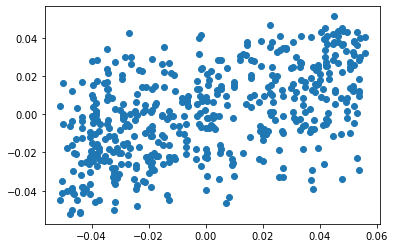

In [119]:
import seaborn as sns
# sns.heatmap(flatten_and_masked_model_predictions)
import matplotlib.pyplot as plt
plt.plot(
    np.array(flatten_and_masked_model_predictions).mean(1),
    np.array(flatten_and_masked_test_video_betas_glm).mean(1),
    "o",
)

In [120]:
# for each prediction, get the most similar betas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances


def get_most_similar_beta(prediction, betas,metric_func=cosine_similarity):
    similarity = metric_func([prediction], betas)
    most_similar_index = np.argmax(similarity)
    return most_similar_index


most_similar_betas = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas: {len(most_similar_betas)}")
print(f"most_similar_betas: {most_similar_betas}")


# pearsonr from sklearn


most_similar_betas_euclidean = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=euclidean_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_euclidean: {len(most_similar_betas_euclidean)}")
print(f"most_similar_betas_euclidean: {most_similar_betas_euclidean}")

most_similar_betas_manhattan = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=manhattan_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_manhattan: {len(most_similar_betas_manhattan)}")
print(f"most_similar_betas_manhattan: {most_similar_betas_manhattan}")

most_similar_betas_cosine = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=cosine_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_cosine: {len(most_similar_betas_cosine)}")
print(f"most_similar_betas_cosine: {most_similar_betas_cosine}")




Shape of most_similar_betas: 500
most_similar_betas: [210, 210, 3, 3, 379, 379, 174, 174, 257, 257, 258, 258, 195, 195, 184, 184, 397, 397, 18, 18, 175, 175, 381, 381, 497, 497, 294, 294, 200, 200, 373, 373, 345, 345, 257, 257, 262, 262, 174, 174, 378, 378, 257, 257, 104, 104, 200, 200, 197, 197, 51, 51, 303, 303, 375, 375, 328, 328, 262, 262, 89, 89, 118, 118, 127, 127, 397, 397, 428, 428, 262, 262, 469, 469, 121, 121, 482, 482, 263, 263, 197, 197, 273, 273, 262, 262, 375, 375, 335, 335, 105, 105, 184, 184, 476, 476, 240, 240, 400, 400, 100, 100, 103, 103, 34, 34, 227, 227, 109, 109, 77, 77, 174, 174, 115, 115, 143, 143, 197, 197, 381, 381, 122, 122, 258, 258, 384, 384, 34, 34, 457, 457, 227, 227, 381, 381, 200, 200, 51, 51, 231, 231, 122, 122, 56, 56, 257, 257, 457, 457, 345, 345, 259, 259, 2, 2, 172, 172, 387, 387, 89, 89, 208, 208, 262, 262, 328, 328, 381, 381, 257, 257, 400, 400, 174, 174, 345, 345, 303, 303, 100, 100, 121, 121, 184, 184, 490, 490, 121, 121, 109, 109, 129, 129, 39

In [121]:
from scipy.stats import pearsonr


def scores_for_a_prediction(prediction,betas):
    scores = [pearsonr(prediction,beta)[0] for beta in betas]
    return scores



def get_most_similar_beta_corr(prediction, betas):
    scores = scores_for_a_prediction(prediction,betas)
    most_similar_index = np.argmax(scores)
    return most_similar_index

most_similar_betas_corr = [get_most_similar_beta_corr(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_corr: {len(most_similar_betas_corr)}")
print(f"most_similar_betas_corr: {most_similar_betas_corr}")

Shape of most_similar_betas_corr: 500
most_similar_betas_corr: [1, 1, 3, 3, 379, 379, 174, 174, 428, 428, 258, 258, 397, 397, 184, 184, 396, 396, 18, 18, 175, 175, 121, 121, 497, 497, 325, 325, 200, 200, 258, 258, 56, 56, 231, 231, 200, 200, 89, 89, 378, 378, 184, 184, 34, 34, 200, 200, 174, 174, 51, 51, 52, 52, 319, 319, 56, 56, 262, 262, 89, 89, 118, 118, 329, 329, 397, 397, 396, 396, 438, 438, 51, 51, 121, 121, 482, 482, 267, 267, 197, 197, 273, 273, 85, 85, 316, 316, 88, 88, 105, 105, 109, 109, 476, 476, 240, 240, 210, 210, 100, 100, 51, 51, 34, 34, 227, 227, 109, 109, 77, 77, 174, 174, 50, 50, 143, 143, 119, 119, 257, 257, 122, 122, 258, 258, 384, 384, 34, 34, 307, 307, 379, 379, 457, 457, 200, 200, 51, 51, 497, 497, 122, 122, 56, 56, 231, 231, 457, 457, 108, 108, 259, 259, 2, 2, 174, 174, 387, 387, 89, 89, 208, 208, 164, 164, 328, 328, 129, 129, 257, 257, 175, 175, 378, 378, 122, 122, 56, 56, 100, 100, 69, 69, 184, 184, 115, 115, 120, 120, 259, 259, 129, 129, 397, 397, 89, 89, 19

Shape of similarity_matrix: (500, 500)


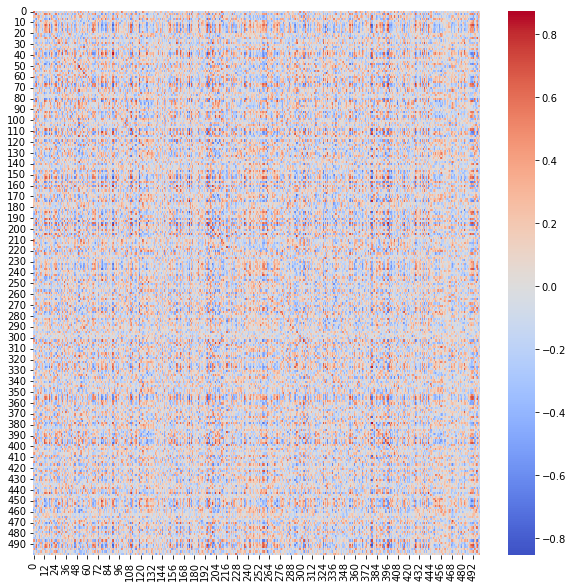

In [122]:
# draw a picture to show the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

similarity_matrix = [scores_for_a_prediction(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]

similarity_matrix = similarity_matrix
similarity_matrix = np.array(similarity_matrix)



print(f"Shape of similarity_matrix: {similarity_matrix.shape}")
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix, cmap="coolwarm", center=0)
plt.show()